In [1]:
import sys
sys.path.append('..')

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.soft_actor_critic import SoftActorCritic
from models.ddpg import DDPG
from rl_models.her_player import Player
from rl_models.replay_buffer import ReplayBuffer
from rl_models.utils import plot_learning_curve

In [3]:
env_name = 'FetchPush-v2'
max_episode_steps = 50
env = gym.make(env_name, max_episode_steps=max_episode_steps)

env.action_space, env.observation_space

(Box(-1.0, 1.0, (4,), float32),
 Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64)))

In [4]:
state_dim = env.observation_space['observation'].shape[0]
goal_dim = env.observation_space['desired_goal'].shape[0]
actions_dim = env.action_space.shape[0]
state_dim, actions_dim

(25, 4)

In [5]:
epochs = 50
epoch_iters = 50
success_history = []
batch_size = 256
gamma = .98

In [6]:
desired_goal = env.reset()[0]['desired_goal']

In [7]:
agent = SoftActorCritic(state_dim + goal_dim, actions_dim, 
             hidden_size=256, lr=1e-3,
              tau=0.5, gamma=gamma
              )
replay_buffer = ReplayBuffer(int(1e6))
player = Player(env, agent, replay_buffer)

-19.96 0.87
Epoch 50
DDPG with HER       success rate = 0.87


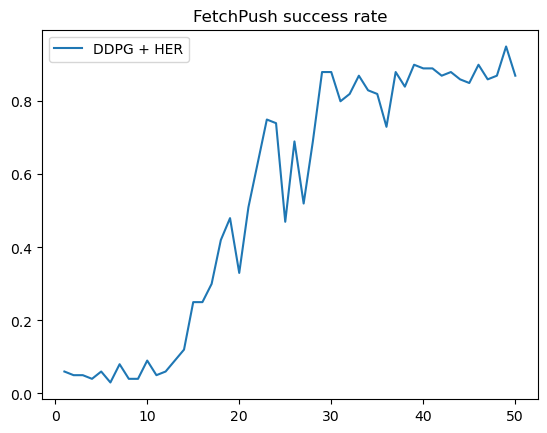

In [13]:
epsilon = .3
for epoch in range(epochs):
    for iter in tqdm(range(epoch_iters)):
        score, success = player.play_and_record(epsilon=epsilon, num_episodes=16)
        batch_size = 1024
        player.update_agent(batch_size=batch_size)


    score, success_rate = player.play_test(n_tests=100)
    success_history.append(success_rate)
    plot_learning_curve(success_history, name="DDPG + HER", title="FetchPush success rate") 
    
    print(f"Epoch {len(success_history)}")
    print(f"DDPG with HER       success rate = {success_rate}")
    plt.show()

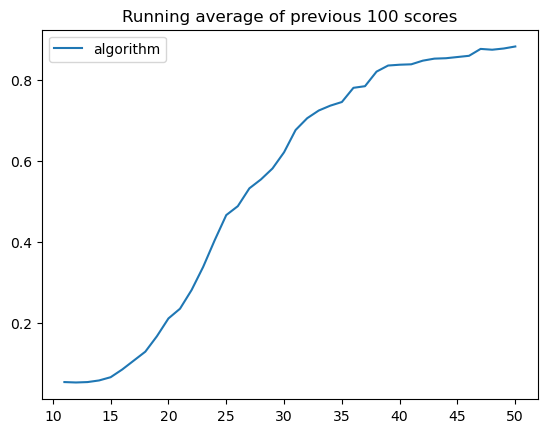

In [17]:
plot_learning_curve([np.mean(success_history[i-10:i]) for i in range(len(success_history))])
plt.savefig('../graphics/sac_fetchpush.png')
plt.show()